In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [22]:
def cartesianToPolar(x, y):
    """ Cartesian to Polar """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def polarToCartesian(rho, phi):
    """ Polar to Cartesian """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

################ functions of RAD processing ################
def complexTo2Channels(target_array):
    """ transfer complex a + bi to [a, b]"""
    assert target_array.dtype == np.complex64
    ### NOTE: transfer complex to (magnitude) ###
    output_array = getMagnitude(target_array)
    output_array = getLog(output_array)
    return output_array

def getMagnitude(target_array, power_order=2):
    """ get magnitude out of complex number """
    target_array = np.abs(target_array)
    target_array = pow(target_array, power_order)
    return target_array 

def getLog(target_array, scalar=1., log_10=True):
    """ get Log values """
    if log_10:
        return scalar * np.log10(target_array + 1.)
    else:
        return target_array

def getSumDim(target_array, target_axis):
    """ sum up one dimension """
    output = np.sum(target_array, axis=target_axis)
    return output 

def switchCols(target_array, cols):
    """ switch columns """
    assert isinstance(cols, tuple) or isinstance(cols, list)
    assert len(cols) == 2
    assert np.max(cols) <= target_array.shape[-1] - 1
    cols = np.sort(cols)
    output_axes = []
    for i in range(target_array.shape[-1]):
        if i == cols[0]:
            idx = cols[1]
        elif i == cols[1]:
            idx = cols[0]
        else:
            idx = i
        output_axes.append(idx)
    return target_array[..., output_axes]

def switchAxes(target_array, axes):
    """ switch axes """
    assert isinstance(axes, tuple) or isinstance(axes, list)
    assert len(axes) == 2
    assert np.max(axes) <= len(target_array.shape) - 1
    return np.swapaxes(target_array, axes[0], axes[1])

def norm2Image(array):
    """ normalize to image format (uint8) """
    norm_sig = plt.Normalize()
    img = plt.cm.viridis(norm_sig(array))
    img *= 255.
    img = img.astype(np.uint8)
    return img

In [81]:

def imgPlot(img, ax, cmap=None, alpha=1, title=None):
    """ image plotting (customized when plotting RAD) """
    ax.imshow(img, cmap=cmap, alpha=alpha)
    if title == "RD":
        title = "Range-Doppler"
        ax.set_xticks([0, 16, 32, 48, 63])
        ax.set_xticklabels([-13, -6.5, 0, 6.5, 13])
        ax.set_yticks([0, 64, 128, 192, 255])
        ax.set_yticklabels([50, 37.5, 25, 12.5, 0])
        ax.set_xlabel("velocity (m/s)")
        ax.set_ylabel("range (m)")
    elif title == "RA":
        title = "Range-Azimuth"
        ax.set_xticks([0, 64, 128, 192, 255])
        ax.set_xticklabels([-85.87, -42.93, 0, 42.93, 85.87])
        ax.set_yticks([0, 64, 128, 192, 255])
        ax.set_yticklabels([50, 37.5, 25, 12.5, 0])
        ax.set_xlabel("angle (degrees)")
        ax.set_ylabel("range (m)")
    elif title == "DA":
        title = "Doppler-Azimuth"
        ax.set_xticks([0, 64, 128, 192, 255])
        ax.set_xticklabels([-85.87, -42.93, 0, 42.93, 85.87])
        ax.set_yticks([0, 16, 32, 48, 63])
        ax.set_yticklabels([-13, -6.5, 0, 6.5, 13])
        ax.set_xlabel("angle (degrees)")
        ax.set_ylabel("velocity (m/s)")
    elif title == "Cartesian":
        ax.set_xticks([0, 128, 256, 384, 512])
        ax.set_xticklabels([-50, -25, 0, 25, 50])
        ax.set_yticks([0, 64, 128, 192, 255])
        ax.set_yticklabels([50, 37.5, 25, 12.5, 0])
        ax.set_xlabel("x (m)")
        ax.set_ylabel("z (m)")
    else:
        ax.axis('off')
    if title is not None:
        ax.set_title(title)

# RAD_data is raw data, comlpex maybe
def plot_RAD(RAD_data, raw=False):
    """ plot RAD data , [R, A, D]"""
    if raw:
        RA = getLog(getSumDim(getMagnitude(RAD_data, power_order=2), target_axis=-1), scalar=10., log_10=True)
        RD = getLog(getSumDim(getMagnitude(RAD_data, power_order=2), target_axis=1), scalar=10., log_10=True)
        DA = getLog(getSumDim(getMagnitude(RAD_data, power_order=2).transpose(2, 0, 1), target_axis=1), scalar=10., log_10=True)
    else:
        RA = getSumDim(RAD_data, target_axis=-1)
        RD = getSumDim(RAD_data, target_axis=1)
        DA = getSumDim(RAD_data.transpose(2, 0, 1), target_axis=1)
    
    RA_img = norm2Image(RA)[..., :3]
    RD_img = norm2Image(RD)[..., :3]
    DA_img = norm2Image(DA)[..., :3]

    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    # axes[0].imshow(RA_img)
    # axes[1].imshow(RD_img)
    # axes[2].imshow(DA_img)
    imgPlot(RA_img, axes[0], title="RA")
    imgPlot(RD_img, axes[1], title="RD")
    imgPlot(DA_img, axes[2], title="DA")
    plt.tight_layout()
    # pcm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    # pcm = axes[-1].pcolormesh(np.random.rand(10, 10), cmap=plt.cm.viridis)
    # fig.colorbar(pcm, ax=axes[0], shrink=0.6, orientation='vertical', fraction=0.02, pad=0.04)
    # 创建全局 colorbar
    cmap = plt.cm.viridis
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)  # 设置 colorbar 范围
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), 
                        ax=axes[-1], orientation='vertical', 
                        fraction=0.05, pad=0.05,shrink=0.8,
                        # location = 'left'
                        )
    plt.show()

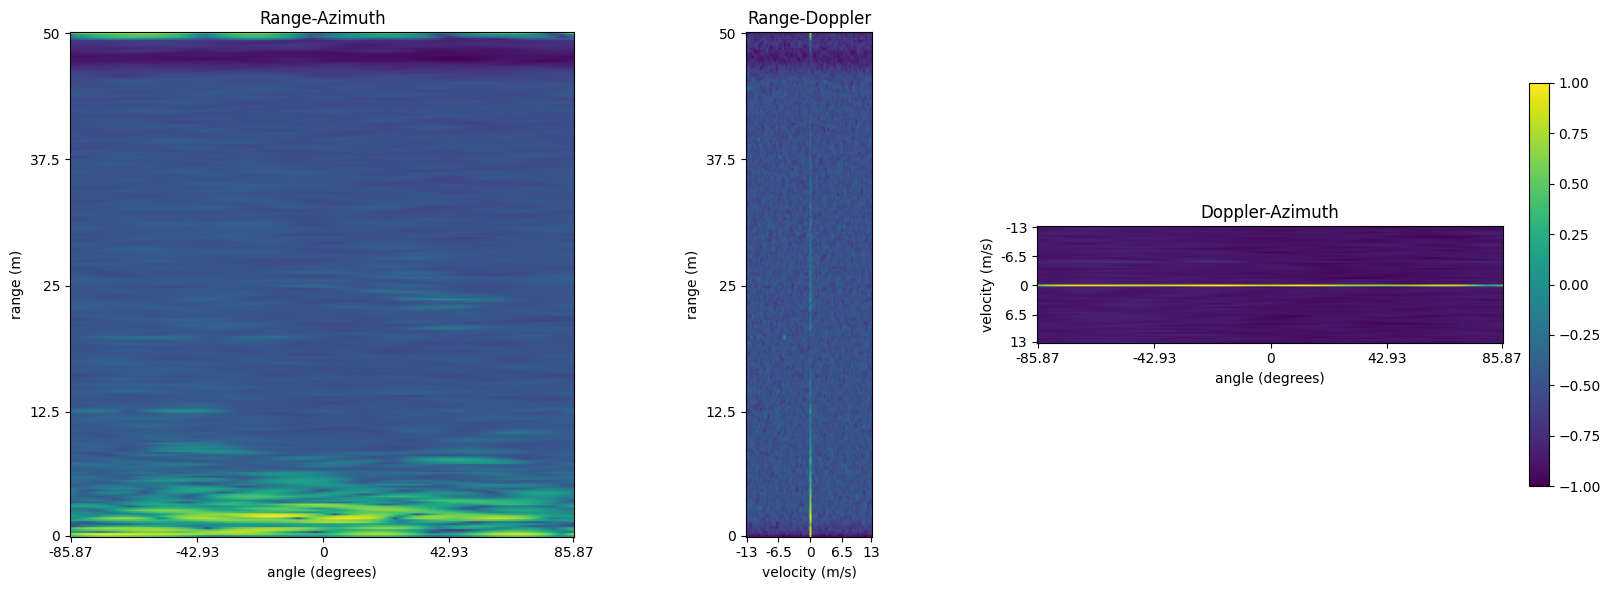

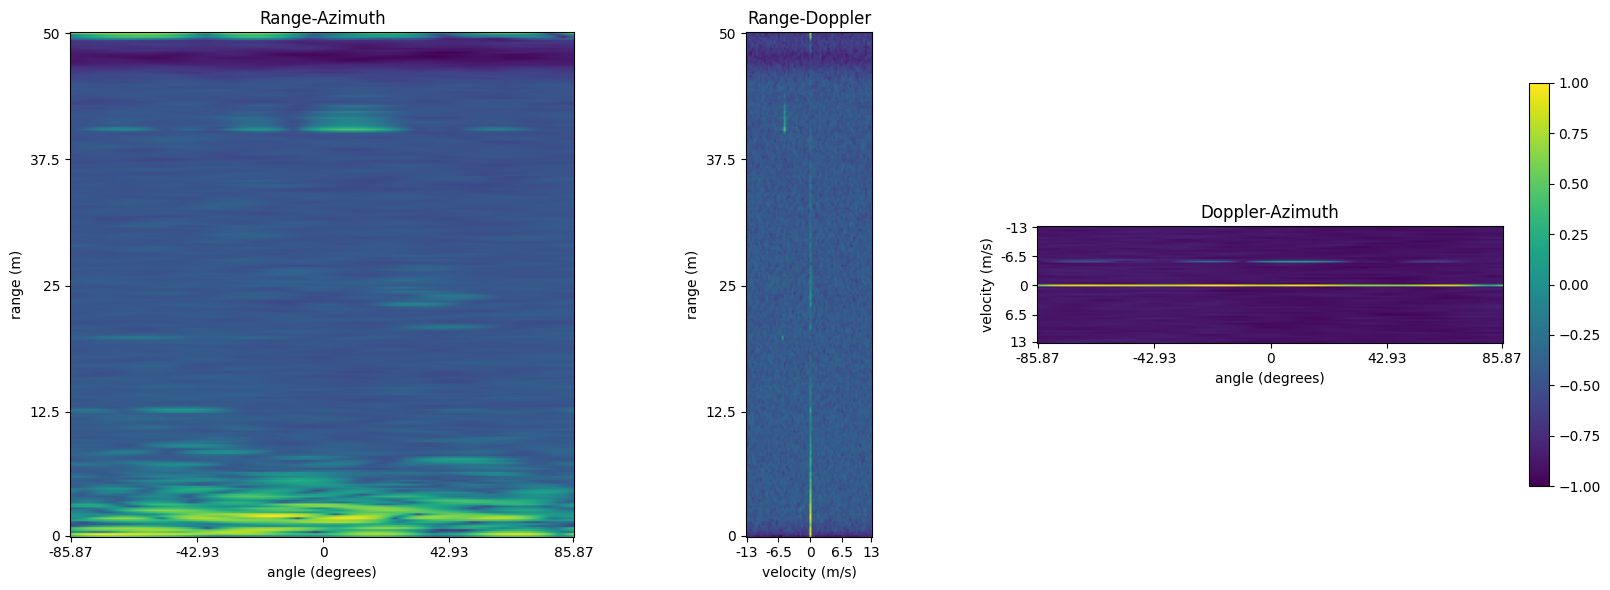

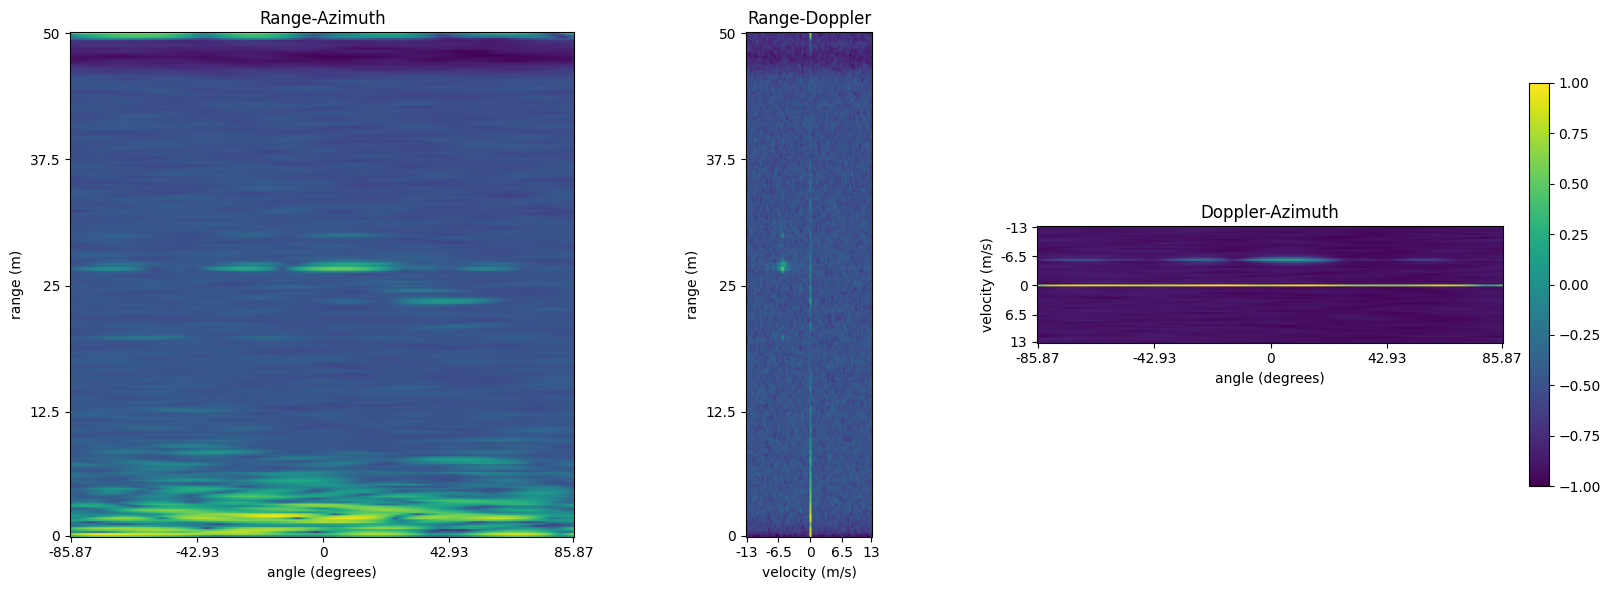

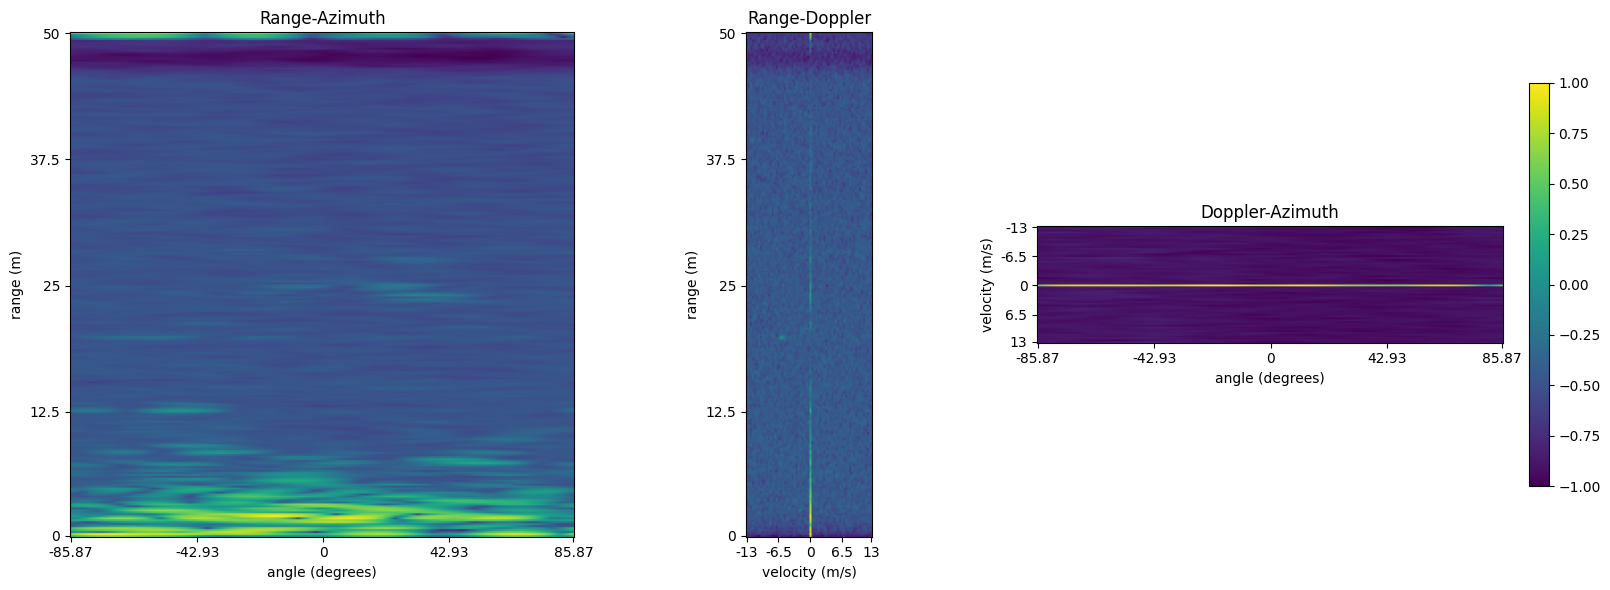

In [82]:
import glob
import os
import numpy as np

data_dir = '/mnt/SrvDataDisk/Datasets_Radar/CARRADA'
sequences_all = glob.glob(os.path.join(data_dir, "Carrada_RAD", "*/*/*.npy"))

idx = 0
for filename in sequences_all:
    if idx > 3:
        break
    data = np.load(filename)
    plot_RAD(data, raw=True)
    idx += 1